In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import os
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
con = sqlite3.connect('../database.sqlite')  # making a connection to the database to be present in the same directory 

## Data Cleaning 1, Positive-Negative score reformatting

In [4]:
odata = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) # retrieving reviews with score not equal to 3
orig_shape = odata.shape
odata

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [10]:
# First query to get ProductIds
product_query = """
SELECT ProductId
FROM Reviews
GROUP BY ProductId
HAVING COUNT(*) > 10 AND AVG(Score) < 3
"""
product_ids = pd.read_sql_query(product_query, con)

# Now use the ProductIds to get the Summary and Text for each
summary_text_query = f"""
SELECT ProductId, Summary, Text
FROM Reviews
WHERE ProductId IN ({','.join('?'*len(product_ids))})
"""
summary_text_data = pd.read_sql_query(summary_text_query, con, params=product_ids['ProductId'].tolist())


In [11]:
product_ids

,ProductId
0,B00002N8SM
1,B00008MOIF
2,B0000DGG8D
3,B00016Q6DS
4,B0001AVRQK
...,...
261,B007SMGN9A
262,B0085MLY5A
263,B0096ARSSW
264,B0099HD3YA


In [26]:
summary_text_data.iloc[5]

ProductId                                           B005HGAVGK
Summary                                        Not all Summer?
Text         We definately got a nice assortment of K-Cups ...
Name: 5, dtype: object

In [4]:
# assigning a score of 1 to reviews with rating > 3 and a score of 0 to reviews with rating < 3, we discarded the reviews with 
# rating equal to 3 and we replaced the score column with the new scale 
def partition(x):
    if x < 3:
        return 0
    return 1


data = odata.copy()
scores = data['Score'].map(partition)
data['Score'] = scores
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


## Data cleaning 2 - Delete duplicates

In [5]:
# The below data is the rows which are duplicates , we exclude them from the data
dups = data[data.duplicated(['UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'], keep=False)]
# we keep the duplicates and sort them for display
sorted_dups=dups.sort_values('UserId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_dups

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
166820,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,0,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
76583,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,0,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
268373,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,1,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
421207,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,1,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
459536,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,1,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
...,...,...,...,...,...,...,...,...,...,...
213538,231424,B003FDC2I2,AZZU1VEO8KUXH,"Mia P ""Mia P""",1,1,1,1317513600,NOT like the others,I bought this for my 13 year old daughter who ...
373695,404101,B003FDG4K4,AZZU1VEO8KUXH,"Mia P ""Mia P""",1,1,1,1317513600,NOT like the others,I bought this for my 13 year old daughter who ...
272167,294985,B005V9UG18,AZZU1VEO8KUXH,"Mia P ""Mia P""",1,1,1,1317513600,NOT like the others,I bought this for my 13 year old daughter who ...
382989,414107,B0029XEXZE,AZZU4D6TZ2L6J,"Sherry King ""llamasmama""",2,2,1,1247875200,cheese,My father thought this was the best cheese eve...


In [6]:
cdata=data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
cdata # data without duplicates 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


## Data Cleaning 3 - removing inconsistencies

* We cannot have data points where the helpfulness numerator is greater than the helpfulness denominator, we remove such inconsistencies 
* Helpfullness numerator is the number of people who marked the review helpful , where as the Helpfulness denominator is the total number of the people who marked the review helpful or not helpful 

In [7]:
data[data["HelpfulnessNumerator"] > data["HelpfulnessDenominator"]]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [8]:
cdata = cdata[cdata["HelpfulnessNumerator"] <= cdata["HelpfulnessDenominator"]] # cleaned ata after removing inconsistencies 
fin_shape = cdata.shape
cdata

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [9]:
fin_shape[0]/orig_shape[0]
# The number of records retained after removing duplicates is 69.25%

0.6925852107399194

## Data cleaning 4 - Reformatting date

In [10]:
cdata['Time'] = pd.to_datetime(cdata['Time'], unit="s")
# ndata['Time'].dt.year
cdata['Day'] = cdata['Time'].dt.day
cdata['Month'] = cdata['Time'].dt.month
cdata['Year'] = cdata['Time'].dt.year

In [11]:
cdata

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Day,Month,Year
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,27,4,2011
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,7,9,2012
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,18,8,2008
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,13,6,2011
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,21,10,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,2011-03-09,Will not do without,Great for sesame chicken..this is a good if no...,9,3,2011
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,2012-03-09,disappointed,I'm disappointed with the flavor. The chocolat...,9,3,2012
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,2012-02-21,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",21,2,2012
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,2012-03-13,Favorite Training and reward treat,These are the BEST treats for training and rew...,13,3,2012


## Data Cleaning 5-12:
1. Remove the http links in the reviews
2. Remove the html tags
3. Remove any punctuations or limited set of special characters like , or . or # etc.
4. Check if the word is made up of english letters and is not alpha-numeric
5. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
6. Convert the word to lowercase
7. Remove Stopwords
8. Finally Snowball Stemming the word (it was observed to be better than Porter Stemming)

In [12]:
snow_stemmer = SnowballStemmer(language='english')


In [13]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [14]:
def preprocess(sentence):
    sentence = re.sub(r"http\S+", "", sentence)# we remove the http links
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # this will remove all the tags and extract the text inside every tag
    sentence = decontracted(sentence) # this will decontract all the words in the string 
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # this removes words with numbers in it 
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removing any punctuations or special charecters 
    sentence = ' '.join(snow_stemmer.stem(e.lower()) for e in sentence.split() if e.lower() not in STOPWORDS and len(e)>2) 
    sentence = sentence.strip()
    # lower case conversion , stop word removal and stemming done in the above loop, we only look for words with length >2 
    return sentence 

In [15]:
sampled_data = cdata.sample(n=100, random_state=42)
sampled_data # sampling some data points from the cleaned data just for display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Day,Month,Year
380504,411429,B000G1EO1Y,AGU9QVBWHBH6L,Y. E. Pelletier,0,0,0,2008-03-30,Onions overwhelm otherwise low-key flavor,"The onions are overwhelming in a sharp, bitter...",30,3,2008
485251,524729,B002DHNIBG,A2SZWFJX0783BF,Willow,19,21,1,2010-02-17,Mocha Heaven,Pros:<br />Great mocha taste that doesn't over...,17,2,2010
673,725,B000G6MBX2,A1KBNKFKAWYV7L,Charles R. Bock,0,2,1,2007-08-10,Very Timely Delivery,They did a very good job with shipping the ord...,10,8,2007
77795,84614,B000FK63IS,A2ZF652T71JKBX,"G. Terry ""Otaku Bibliophile""",2,2,1,2010-05-29,I am VERY Picky About Texture,I have heightened sensitivity to touch/texture...,29,5,2010
492291,532257,B006G67A1Y,A3AKHTK5K6SCGT,Nathan Taylor,2,2,1,2012-02-23,Even Better,"This is our second order, we first got the 35 ...",23,2,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96376,104735,B006N3I69A,A13TOSL8QG2BD6,Bobbi,0,0,0,2011-06-09,Would not recommend,These cups are simply little plastic container...,9,6,2011
146286,158690,B001189I3A,A1TGPJCQLZIRCB,Mishiemonroe,3,3,0,2012-03-02,Does not work!,I've used this product over the past few days ...,2,3,2012
285364,309138,B0014K91GY,A2M78EOXPAF1D0,"John L. Grosbeck ""scoobydoozie""",5,6,0,2008-10-09,Extemely week-anorexic for hot chocolate,Don't waste your money on this. It's awful. S...,9,10,2008
285844,309650,B0042DA7H2,AOXGI0GZW2VO2,"SKC ""Puff Piece""",1,1,1,2012-02-10,Tasty & delicious Lemon Curd,"We are huge fans of ""Mrs. Bridges Lemon Curd, ...",10,2,2012


In [16]:
sampled_data['Text'] = sampled_data['Text'].map(preprocess) 

In [17]:
sentences_0 = list(sampled_data[sampled_data["Score"] == 0]['Text'])
text_0 = ' '.join([x for x in sentences_0])
sentences_1 = list(sampled_data[sampled_data["Score"] == 1]['Text'])
text_1 = ' '.join([x for x in sentences_1])

## EDA 1- Score distribution 

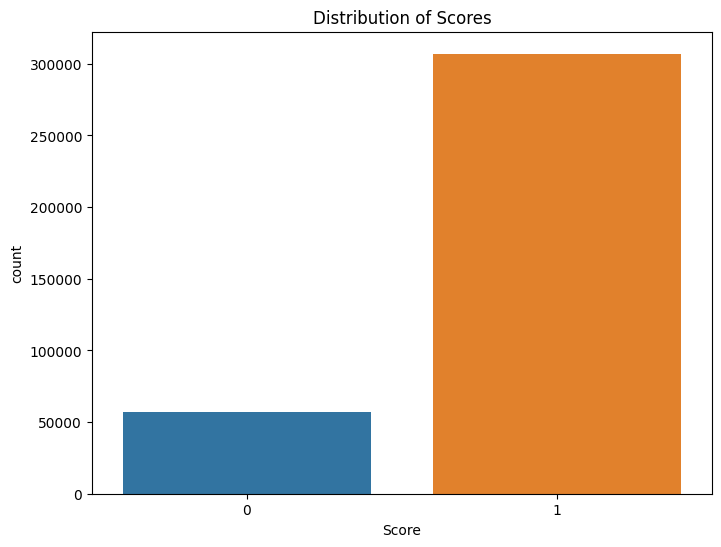

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# 1. Distribution of Scores
plt.figure(figsize=(8, 6))
sns.countplot(data=cdata, x='Score')
plt.title('Distribution of Scores')
plt.show()

## EDA 2- Number of reviews over years 

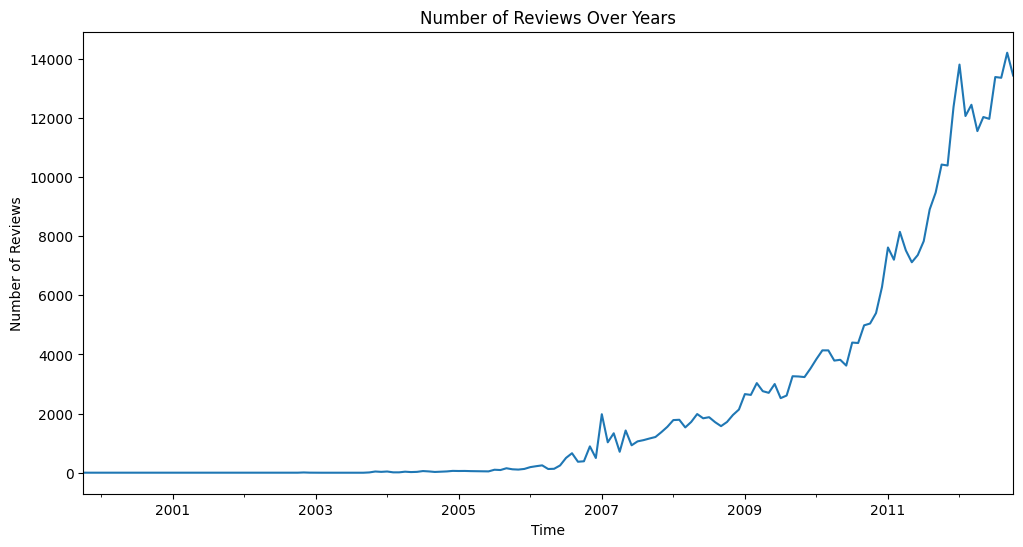

In [19]:
# 2. Number of Reviews Over Time
monthly_reviews = cdata.groupby(cdata['Time'].dt.to_period("M")).size()
monthly_reviews.plot(figsize=(12, 6))
plt.title('Number of Reviews Over Years')
plt.ylabel('Number of Reviews')
plt.show()


## EDA 3- Number of reviews over months 

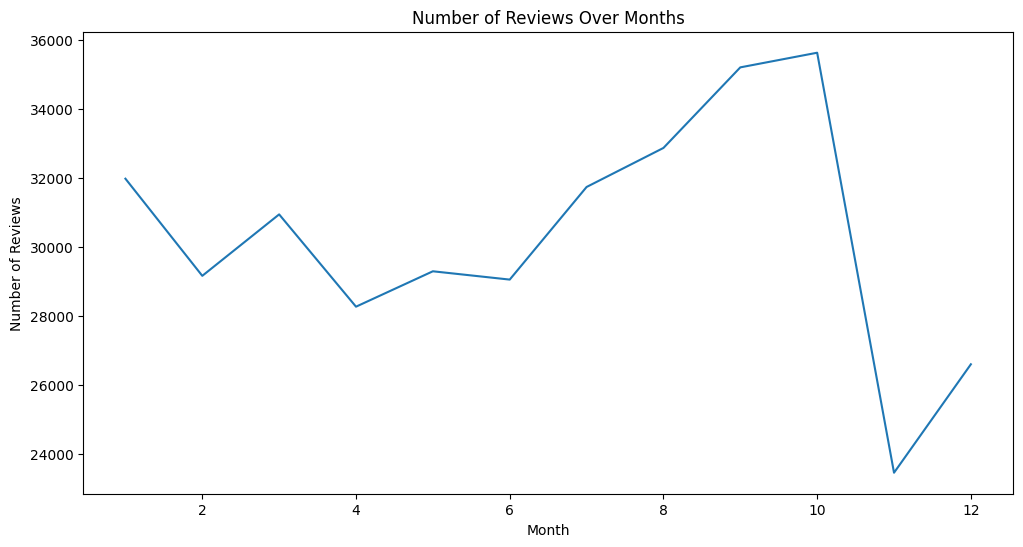

In [20]:
# 3. Number of Reviews Over Time
monthly_reviews = cdata.groupby(cdata['Month']).size()
monthly_reviews.plot(figsize=(12, 6))
plt.title('Number of Reviews Over Months')
plt.ylabel('Number of Reviews')
plt.show()


In [21]:
# creating a new dataframe from the text and score columns from the entire cleaned dataframe (cdata) after preprocessing text
processed_data = cdata['Text'].map(preprocess).to_frame(name='ProcessedText')
processed_data['Score']=cdata['Score']

In [22]:

stopwords = set(STOPWORDS)
positive_text = " ".join(review for review in processed_data[processed_data['Score'] == 1]['ProcessedText'])
negative_text = " ".join(review for review in processed_data[processed_data['Score'] == 0]['ProcessedText'])

## EDA 4- Distribution of Review Lengths: Positive vs. Negative

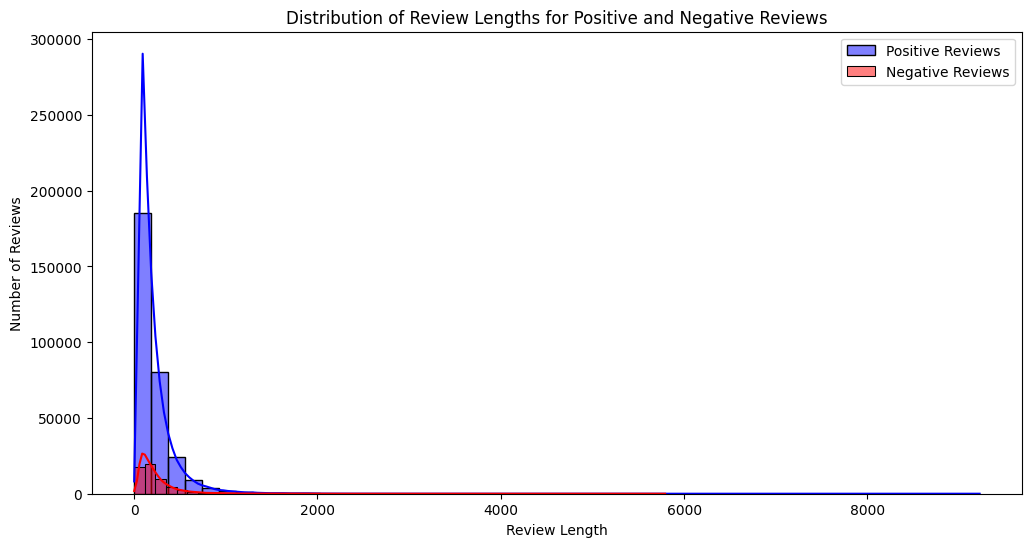

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the length of each review
processed_data['review_length'] = processed_data['ProcessedText'].apply(len)

# Plot the distribution of review lengths for positive and negative reviews
plt.figure(figsize=(12, 6))

sns.histplot(processed_data[processed_data['Score'] == 1]['review_length'], color='blue', label='Positive Reviews', kde=True, bins=50)
sns.histplot(processed_data[processed_data['Score'] == 0]['review_length'], color='red', label='Negative Reviews', kde=True, bins=50)

plt.title('Distribution of Review Lengths for Positive and Negative Reviews')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()


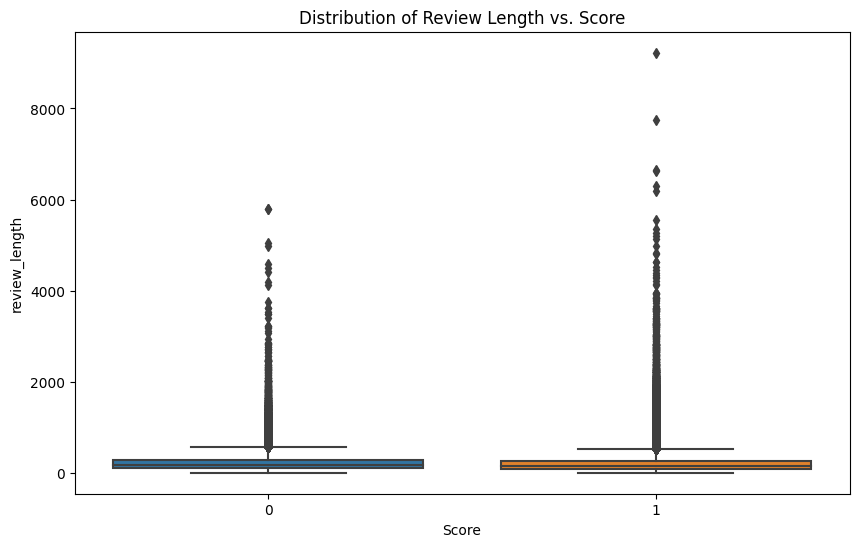

In [24]:
# box plot for the same 
plt.figure(figsize=(10, 6))
sns.boxplot(data=processed_data, x='Score', y='review_length')
plt.title('Distribution of Review Length vs. Score')
plt.show()

## EDA5 wordclouds for positive and negative classes


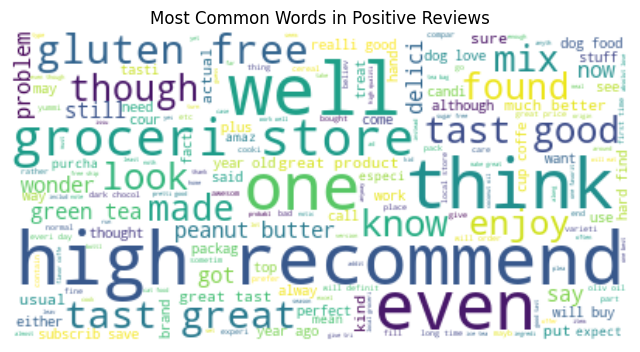

In [25]:
# Positive reviews word cloud
wordcloud_pos = WordCloud(stopwords=stopwords, background_color="white").generate(positive_text)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Positive Reviews')
plt.show()

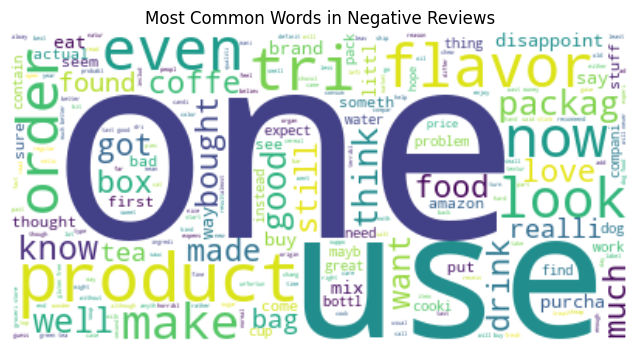

In [26]:
# Negative reviews word cloud
wordcloud_neg = WordCloud(stopwords=stopwords, background_color="white").generate(negative_text)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Negative Reviews')
plt.show()